<a href="https://colab.research.google.com/github/Ignacio-Ibarra/NLP-Disasters/blob/master/TP1_version_Ale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud
import PIL
import itertools
from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string



%matplotlib inline

#para suprimir notacion cientifica en los outputs
pd.options.display.float_format='{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Google Drive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [149]:
link='https://drive.google.com/open?id=1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')

# Carga DF

In [151]:
#Loading 'train.csv' into DataFrame
train=pd.read_csv('train.csv')
train.head(10) #Let's have a first view of the DataFrame

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [152]:
print('El DataFrame cuenta con {} filas y {} columnas'.format(train.shape[0],train.shape[1]))

El DataFrame cuenta con 7613 filas y 5 columnas


# Cleaning de tweets repetidos

In [153]:
duplicated=train.groupby(['text']).agg({'target':['count','nunique']}).reset_index()
duplicated.sort_values(by=('target','count'),ascending=False).head(10)

text target        
                                                         count nunique
646   11-Year-Old Boy Charged With Manslaughter of T...     10       1
45    #Bestnaijamade: 16yr old PKK suicide bomber wh...      6       1
6131  The Prophet (peace be upon him) said 'Save you...      6       2
3589  He came to a land which was engulfed in tribal...      6       2
4589  Madhya Pradesh Train Derailment: Village Youth...      5       1
7372  that horrible sinking feeling when youÛªve be...      4       2
6353                         To fight bioterrorism sir.      4       2
610   .POTUS #StrategicPatience is a strategy for #G...      4       2
6574  VIDEO: 'We're picking up bodies from water': R...      4       1
1540  @TinyJecht Are you another Stand-user? If you ...      3       1

Se observa que hay tweets que se repiten hasta 10 veces. A su vez, existen tweets a los que se les asignaron 2 targets al mismo tiempo (columna nunique). Esos datos se deben eliminar ya que afectan al set de entrenamiento.

In [0]:
contradiction=train.loc[:,['text','target']].groupby(['text']).transform('nunique')
train['count_targets']=contradiction
train=train[train.count_targets==1]
train.drop('count_targets',axis=1,inplace=True)

Una vez eliminados los tweets contradictorios, se eliminan los tweets duplicados (salvo la primera ocurrencia)

In [0]:
train.drop_duplicates(subset ='text', keep = 'first', inplace = True)

In [156]:
print('El DataFrame post cleaning cuenta con {} filas y {} columnas'.format(train.shape[0],train.shape[1]))

El DataFrame post cleaning cuenta con 7485 filas y 5 columnas


# Proporción de Target Real/Not Real

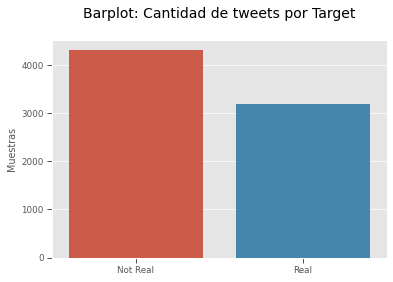

In [157]:
#Cantidad de muestras 
sns.set_context('paper')

x=train['target'].value_counts()
g=sns.barplot(x.index,x)
g.set_title('Barplot: Cantidad de tweets por Target\n',fontsize=14)
g.set_ylabel('Muestras')
plt.xticks([0, 1], ['Not Real', 'Real'])
plt.show()


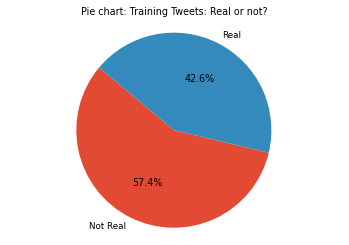

In [158]:
labels='Not Real','Real'
g2=plt.pie(x,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Pie chart: Training Tweets: Real or not?')
plt.show()


Se observa mayor proporción de tweets de clase "Not Real" sobre los de clase "Real". 

Se puede dividir el DF en 2 subsets

In [0]:
train1=train[train['target']==1]
train0=train[train['target']==0]

# Análisis de Keywords

In [0]:
def percent_real_disaster(x):
    return x.mean()*100 


grouped=train.groupby(['keyword']).agg({'target':[percent_real_disaster]}).sort_values(by=('target','percent_real_disaster'),ascending=False)
grouped=grouped.reset_index()


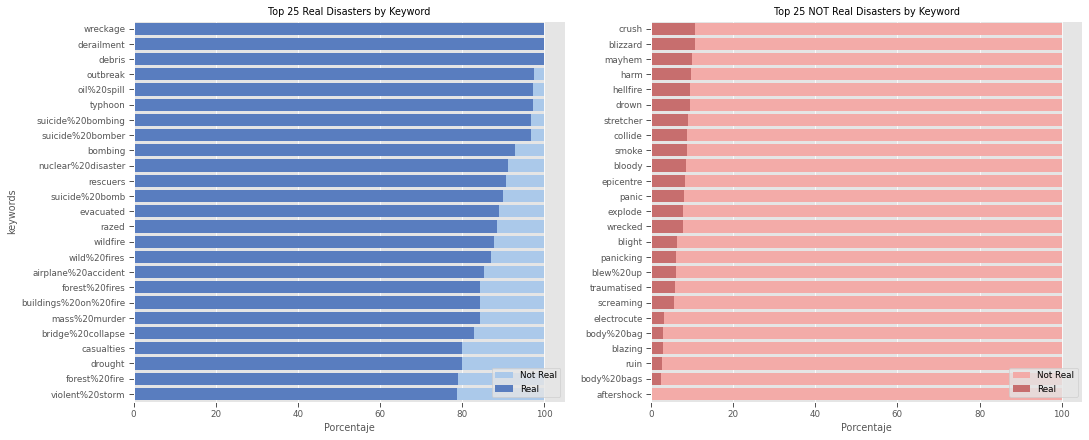

In [161]:
#Plot 
sns.set_context('paper')
#Ploteo el total de tweets por keyword
f, axes = plt.subplots(1,2, figsize=(17, 7), sharex=True)

#Los keywords con mayor proporción de tweets Reales
sns.set_color_codes("pastel")
g1=sns.barplot(ax=axes[0],x=100,y='keyword',data=grouped.head(25),label='Not Real', color="b")
sns.set_color_codes("muted")
sns.barplot(ax=axes[0],x=('target','percent_real_disaster'),y='keyword',data=grouped.head(25), label='Real',color="b")
g1.set_ylabel('keywords')
g1.set_xlabel('Porcentaje')
g1.set_title('Top 25 Real Disasters by Keyword')

#los peores 10
sns.set_color_codes("pastel")
g2=sns.barplot(ax=axes[1],x=100,y='keyword',data=grouped.tail(25), label='Not Real',color="r")
sns.set_color_codes("muted")
sns.barplot(ax=axes[1],x=('target','percent_real_disaster'),y='keyword',data=grouped.tail(25),label='Real', color="r")
g2.set_ylabel('')
g2.set_xlabel('Porcentaje')
g2.set_title('Top 25 NOT Real Disasters by Keyword')

# Legend
g1.legend(ncol=1, loc="lower right", frameon=True)
g2.legend(ncol=1, loc="lower right", frameon=True)

plt.show()

En la figura se la izquiera se ilustran 25 keywords con porcentajes de Target "Real" mayores al 75%. Se observan keywords referentes a desastres naturales (*drought, forest fire, violent storm)* o edilicios (*bridge collapse, buildings on fire*). También se encuentran tragedias mortales (*mass murder, airplane accident, nuclear disaster, suicide bombing*). Otros keywords incluyen lenguaje de noticias (*casualties, evacuated, rescuers*). 

Por otro lado, en la figura de la derecha, se observan los 25 keywords con menores porcentajes de veracidad. En su mayoría se trata de palabras que servirían para describir tragedias pero que a su vez pueden usarse en muchos otros contextos. Un ejemplo de esto es el keyword "body bag", con un porcentaje de targets Reales menor al 5%. El término por si solo sonaría alarmante, pero veamos las acepciones de la palabra:

1.   Bolsa para guardar cadáveres
2.   Una clase de cartera
3.   Según *Urban Dictionary*, "To boddybag an oponent" es asegurar la victoria sobre el oponente (algo así como "kick ass"), es un slang muy utilizado en las batallas de rap.
4.   Otra acepción de *Urban Dictionary*, "Bodybagging" es robarle un chiste a otro comediante y hacerlo pasar como propio. 






# Cleaning: elimino signos de puntuación

Se eliminan los signos de puntuación salvo @ y # ya que representan elementos del tweet (hashtags y mentions).

In [0]:

def deletePunctuation(inputString):
  aux=string.punctuation
  puncts=aux.translate(str.maketrans("#@","  "))
  auxstring=" " * len(puncts)
  outputString=inputString.translate(str.maketrans(puncts,auxstring))
  return outputString

train['text'] = train['text'].apply(lambda x: deletePunctuation(x))


# Análisis de Pronombres

Se propone un análisis de cantidad de apariciones de pronombres en tweets según su target.

In [0]:
def generate_tokens(target):
    text_tokens=[]
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo tweets con target Not Real
corpus=generate_tokens(0)

dic=defaultdict(int)
pronouns={'I','me','my','mine','myself','you','your','yours','yourself',\
          'he','him','his','himself','she','her','hers','herself',\
          'it','its','itself','we','us','our','ours','ourselves',\
          'they','them','their','theirs','themselves','yourselves'}

for word in corpus:
    if word in pronouns:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]
x0,y=zip(*top0)
y0=tuple(i/(len(train0['text'])) for i in y)

#Analizo tweets con target Real

text_tokens=generate_tokens(1)
dic=defaultdict(int)

for word in text_tokens:
    if word in pronouns:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]
x1,y=zip(*top1)
y1=tuple(i/(len(train1['text'])) for i in y)





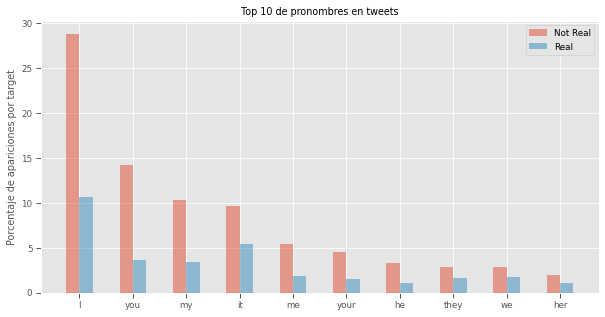

In [164]:
pronouns0=pd.DataFrame(top0,columns=['pronoun','cantidad_not_real'])
pronouns1=pd.DataFrame(top1,columns=['pronoun','cantidad_real'])

pronouns=pronouns0.merge(pronouns1, how='inner')
pronouns['cantidad_not_real']=100*pronouns['cantidad_not_real']/len(train0)
pronouns['cantidad_real']=100*pronouns['cantidad_real']/len(train1)

# Setting the positions and width for the bars
pos = list(range(len(pronouns['pronoun']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with cantidad_not_real data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        pronouns['cantidad_not_real'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with label the first value in first_name
        label=pronouns['pronoun'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        pronouns['cantidad_real'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5,  
        # with label the second value in first_name
        label=pronouns['pronoun'][1]) 

# Set the y axis label
ax.set_ylabel('Porcentaje de apariciones por target')

# Set the chart's title
ax.set_title('Top 10 de pronombres en tweets')


# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(pronouns['pronoun'])


# Adding the legend and showing the plot
plt.legend(['Not Real', 'Real'], loc='upper right')
plt.show()

En la figura se observan los pronombres con más apariciones para ambos targets. Se observa que los mismos 10 pronombres aparecen en ambos rankings. Sin embargo, todos los porcentajes de aparición de target Not Real superan a los de target Real. En partircular, los valores de "I", "you" y "my" para los targets Not Real triplican en porcentaje a los de target Real. 
La naturaleza de un tweet que expresa un desastre responde a un estilo de redacción con poca cantidad de pronombres respecto a un tweet "normal". Esto puede deberse a que no suele usarse la primera ni segunda persona del singular, y pueden haber mayor cantidad de nombres propios.

# Análisis de características de tweets

In [0]:
def hasNumbers(inputString):
  return any(w.isdigit() for w in str(inputString).split())

train['characters_count'] = train['text'].apply(lambda x: len(str(x)))
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w]))
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
train['digits'] = train['text'].apply(lambda x: hasNumbers(x))


In [166]:
train
 

,id,keyword,location,text,target,characters_count,word_count,unique_word_count,url_count,hashtag_count,mention_count,digits
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,13,0,1,0,False
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,38,7,7,0,0,0,False
2,5,NaN,NaN,All residents asked to shelter in place are ...,1,133,22,18,0,0,0,False
3,6,NaN,NaN,13 000 people receive #wildfires evacuation or...,1,65,9,9,0,1,0,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,15,0,2,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G link tram U...,1,136,23,23,1,1,0,True
7605,10864,NaN,NaN,on the flip side I m at Walmart and there is a...,1,114,27,25,0,0,0,False
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,121,19,19,1,0,0,True
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,14,14,1,0,0,False


In [0]:
s1=string.punctuation
outputString=s1.translate(str.maketrans("#@","  "))
